# Demo. Decoder Basics

In [2]:
import stim
import pymatching
import sys
sys.path.append("../QEC-Codes")  # Adjust the path to import local modules
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from numpy.typing import NDArray
import pandas as pd
import seaborn as sns
import time
from sklearn.metrics import r2_score

In [3]:
# QASM export setup (similar to surface_code_ler)
import os, sys, importlib
qasm_dir = "./bb_code_qasm"
os.makedirs(qasm_dir, exist_ok=True)
# Make sure we can import the conversion utilities
sys.path.insert(0, os.path.abspath("../../../src"))
import noise_util as ns
importlib.reload(ns)

<module 'noise_util' from '/hpc/home/garn195/NWQ-Sim/stabilizer/src/noise_util.py'>

This demo introduces the basics of decoders, focusing on pymatching and BP+OSD.  

**What does decoder do?**  
The input is the error information/syndromes/detection events, along with the detector error model that assigns probability/weights to each error mechanism. For each sample, the decoder will return a vector that gives the predictions for the logical errors that have happened (for surface code it's just one value because there is only one logical operator, for general codes it should a vector).

### 1. Pymatching for repetition codes

### Overall Analysis  
**LER decreases with increasing code distance and decreasing physical error rate (PER).**  
This behavior is consistent with theoretical expectations: as the code distance increases, more physical errors are required to cause a logical error. Similarly, reducing the physical error rate naturally reduces the probability of uncorrectable faults.

<!-- (2) **The break-even PER appears to be ≈ 1, meaning the repetition code always outperforms a single bit.**  
At first glance, this seems to contradict the classical result that repetition codes only outperform a single bit when \( p < 0.5 \) — since majority vote fails above this threshold. However, the classical result is based on **majority vote decoding**, whereas our experiment uses a **matching decoder** (e.g., `pymatching`), which finds the most likely error consistent with the observed syndrome, and can operate effectively even at high error rates. As a result, it can outperform majority vote and maintain logical error suppression for a much wider range of \( p \), even approaching 1.

(3) **The error threshold appears to be >0.5, meaning that increasing the code distance can suppresses the LER even when the PER is large.**  
In standard fault-tolerance theory, a threshold exists below which increasing the code distance improves logical fidelity, and above which larger codes perform worse. Here, because we are using the powerful **matching decoder** on this simple repetition code, the threshold become very large (>0.5). -->

### Analysis of LER Scaling

In principle, a QEC code of distance $d$ can correct up to $t = \lfloor \frac{d-1}{2} \rfloor$ errors. In the **ideal** case where all these errors are corrected, the leading-order contribution to the LER should be $p^{t+1}$, where $t + 1 = \lceil \frac{d+1}{2} \rceil$ is the weight of uncorrectable errors. In this case, a log-log plot of LER vs $p$ should produce a straight line with slope $t + 1$.

In realistic scenarios, however, decoding is imperfect: some correctable errors of weight ≤ $t$ may still lead to logical failure due to decoder suboptimality. As a result, the effective scaling exponent becomes **less than** $t + 1$.

Therefore, by fitting the log-log curve $\log(\text{LER})$ vs $ \log(p) $, we can estimate the effective suppression exponent. The **closer the slope is to t+1**, the more effective the decoder is at approaching the ideal case. Conversely, the difference between the slope and the ideal case quantifies suboptimal correction performance under the given noise model and decoding strategy. We can see that when d increases, the leading degrees become closer to t than t+1 and haves the tendency to drop even below t, indicating the fact that it becomes more and more difficult to correct all the errors up to weight t.  

The equation $$slope = (d_{eff}+1)/2 $$can give a metric called the "effective distance $d_{eff}$", which should be strictly smaller than the true distance $d$.

Next, we verify the "exponential suppression" of LER in code distance.

In [4]:
import sinter
from typing import List

This time we try to add the 2Q gate error and measurement error as well.

(1) We kind of see a "threshold behavior": the LER only suppresses as distance increases when PER is below 10.8\%. See where the d = 7 and d = 9 line intersect.  
(2) We also see a "break even" behavior: the LER is belowe PER when p < 10\%, where encoding into repetition code improves the error resilience compared to a bare qubit.

### 2. Pymatching for Surface Codes  
We directly use Sinter to streamline the sampling. This time we include the BPOSD decoder as well.

In [5]:
from bposdd import BPOSD
import BBcode
# from stimbposdd import SinterDecoder_BPOSD, sinter_decoders

In [6]:
import subprocess
import time

# Compile the C++ code once before the loop
print("Compiling C++ simulator (MPI)...")
# Adjust the path to your C++ file as needed
cpp_file_path = './bb_code_sim.cpp'
executable_path = './bb_code_sim'

compile_command = [
    "mpicxx",  # Use MPI compiler wrapper
    "-std=c++17",
    "-O3",
    "-I../../../../../", # Include for NWQ-Sim headers
    "-DMPI_ENABLED",
    "-o",
    executable_path,
    cpp_file_path
]
try:
    subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print("Compilation successful.")
except subprocess.CalledProcessError as e:
    print("Compilation failed.")
    print("--- stdout ---")
    print(e.stdout)
    print("--- stderr ---")
    print(e.stderr)

Compiling C++ simulator (MPI)...
Compilation successful.


In [7]:

# bb_circuit = "bicycle_bivariate_144_12_12_memory_Z"
distance = 12 
rounds = 12
SHOTS = 5000000


In [8]:
#Parameters
tasks = []
T1 = 10 ** -4
T2 = 10 ** -4
tau = np.array([10**-6, 2*10**-6, 3*10**-6, 4*10**-6, 5*10**-6, 6*10**-6, 7*10**-6, 8*10**-6, 9*10**-6, 10**-5])


lam = 1/T2 - 1/(2*T1)
p_amp = 1 - np.exp(-tau/T1)
p_phase = 1 - np.exp(-lam*tau)
p_list = (p_amp, p_phase)

# gate_lam = 1/T2 - 1/(2*T1)
# gate_p_amp = 1 - np.exp(-gate_tau/T1)
# gate_p_phase = 1 - np.exp(-lam*gate_tau)
# gate_p_list = (gate_p_amp, gate_p_phase)
base_error = 10**-3

bb_code = BBcode.BBcode(
    n=144, k=12, d=12, m=6, l=12,
    A=[[3, 0], [0, 1], [0, 2]],
    B=[[0, 3], [1, 0], [2, 0]],
    shift=[0, 0],
    f=[[0, 0], [1, 0], [2, 0], [3, 0], [6, 0], [7, 0], [8, 0], [9, 0], [1, 3], [5, 3], [7, 3], [11, 3]],
    g=[[1, 0], [2, 1], [0, 2], [1, 2], [2, 3], [0, 4]],
    h=[[0, 0], [0, 1], [1, 1], [0, 2], [0, 3], [1, 3]],
    alpha=[[0, 0], [0, 1], [2, 1], [2, 5], [3, 2], [4, 0]],
    beta=[[0, 1], [0, 5], [1, 1], [0, 0], [4, 0], [5, 2]],
)
print(p_amp)
print(p_phase)
i=0
for p_amp, p_phase in zip(p_amp, p_phase):
    noise_profile = [0,0,0,0]
    bb_circuit = bb_code.build_full_BBcode_circuit(rounds=rounds, noise_profile=noise_profile, observable_type="Z", code_capacity=True)

    #Generate stim circuit
    model = ns.ErrorModel(bb_circuit)
    model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
    # model.setting_error('Single_qubit', True, f'PAULI_CHANNEL_1({gate_p_amp/4}, {gate_p_amp/4}, {(.5-gate_p_amp/4-np.sqrt(1-gate_p_amp-gate_p_phase))/2})')
    # model.setting_error('Two_qubit', False, f'PAULI_CHANNEL_1({gate_p_amp/4}, {gate_p_amp/4}, {(.5-gate_p_amp/4-np.sqrt(1-gate_p_amp-gate_p_phase))/2})')
    model.setting_error('Single_qubit', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Two_qubit', False, f'DEPOLARIZE2({base_error})')
    model.setting_error('Measurement', True, f'DEPOLARIZE1({p_amp/2+p_phase/4})') #f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {((1-np.sqrt((1-p_amp)*(1-p_phase)))/2)-p_amp/4})')
    model.setting_error('Reset', True, f'DEPOLARIZE1({p_amp/2+p_phase/4})') #'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {((1-np.sqrt((1-p_amp)*(1-p_phase)))/2)-p_amp/4})')
    stim_circuit = model.generate_noisy_circuit()
    tasks.append(sinter.Task(circuit=stim_circuit, json_metadata={'d': distance, "trial":i}))

    #Generate stabsim circuit
    # model.setting_error('Single_qubit', True, f'DEPOLARIZE1({base_error})')
    # model.setting_error('Two_qubit', True, f'DEPOLARIZE2({base_error})')
    model.setting_error('Measurement', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    model.setting_error('Reset', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    stab_circuit = model.generate_noisy_circuit()
    qasm_output = ns.stim_to_qasm_with_depolarize_noise(stab_circuit)
    # Inject AMPLITUDE_DAMP around M/RESET in QASM using the model settings
    qasm_output = ns.inject_amplitude_damp(qasm_output, model)
    
    try:
        qasm_path = os.path.join(qasm_dir, f"bb_code_d{distance}_p{i}.qasm")
        with open(qasm_path, "w") as f:
            f.write(qasm_output)
    except Exception as e:
        print(f"Failed to export QASM for p={p_amp}: {e}")
    i+=1

print(tau)

[0.00995017 0.01980133 0.02955447 0.03921056 0.04877058 0.05823547
 0.06760618 0.07688365 0.08606881 0.09516258]
[0.00498752 0.00995017 0.01488806 0.01980133 0.02469009 0.02955447
 0.03439458 0.03921056 0.04400252 0.04877058]
[1.e-06 2.e-06 3.e-06 4.e-06 5.e-06 6.e-06 7.e-06 8.e-06 9.e-06 1.e-05]


In [9]:
def run_stim_experiment(tasks, shots):
    stim_lers = []
    for i,task in enumerate(tasks):
        print(f"trial={task.json_metadata.get('trial')}")
        print(f"--- Running Stim for task = {i} ---")
        start_time = time.perf_counter()
        collected_stats = sinter.collect(
            num_workers=os.cpu_count()//4,
            tasks=[task],
            decoders=['bposd'],
            max_shots=shots,
            custom_decoders={
                'bposd': BPOSD(
                    max_iter=1000,
                    bp_method="ms",
                    osd_order=10,
                    osd_method="osd_e"
                )
            },
            print_progress=True,
        )
        stim_time = time.perf_counter() - start_time
        stat = collected_stats[0]
        stim_ler = float(stat.errors) / float(stat.shots)
        # stim_ler = 1 - (1 - (stat.errors / stat.shots))**(1/12)
        if stat.errors == 0: stim_ler = 0
        stim_lers.append(stim_ler)
        print(f"Stim LER: {stim_ler}, Sim+Decoding Time: {stim_time:}s\n")
    return stim_lers

# --- Run Stim-only experiment ---
stim_logical_error_rates = run_stim_experiment(tasks, SHOTS)
print("\nStim complete.")
print("Stim LERs:", stim_logical_error_rates)

try:
    results_dir = "./bposd_results"
    os.makedirs(results_dir, exist_ok=True)
    p_amp_arr = 1 - np.exp(-tau / T1)
    lam = 1 / T2 - 1 / (2 * T1)
    p_phase_arr = 1 - np.exp(-lam * tau)
    stim_results_path = os.path.join(results_dir, f"stim_bposd_results_d{distance}_shots{SHOTS}_newdep.txt")
    with open(stim_results_path, "w") as f:
        f.write("# tau\tp_amp\tp_phase\tstim_ler\n")
        for ta, pa, pp, ler in zip(tau, p_amp_arr, p_phase_arr, stim_logical_error_rates):
            f.write(f"{ta}\t{pa}\t{pp}\t{ler}\n")
    print(f"Saved Stim (BP+OSD) results to {stim_results_path}")
except Exception as e:
    print("Failed to save Stim results:", e)


Starting 112 workers...


trial=0
--- Running Stim for task = 0 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  2m    4999999           0 d=12,trial=0 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  1m    4998655           0 d=12,trial=0 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  1m    4998129           0 d=12,trial=0 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  1m    4997600           0 d=12,trial=0 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  1m    4996816           0 d=12,trial=0 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  1m    4976208           0 d=12,trial=0 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  1m    4970832           0 d=12,trial=0 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0, Sim+Decoding Time: 136.27929447998758s

trial=1
--- Running Stim for task = 1 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd 16m    4999999           0 d=12,trial=1 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999757           0 d=12,trial=1 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999315           0 d=12,trial=1 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998853           0 d=12,trial=1 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998276           0 d=12,trial=1 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4997200           0 d=12,trial=1 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4994000           0 d=12,trial=1 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 2e-07, Sim+Decoding Time: 148.03813118499238s

trial=2
--- Running Stim for task = 2 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999999           0 d=12,trial=2 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999706           0 d=12,trial=2 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999330           0 d=12,trial=2 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998886           0 d=12,trial=2 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998309           0 d=12,trial=2 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4997712           0 d=12,trial=2 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4994384           0 d=12,trial=2 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 1.06e-05, Sim+Decoding Time: 153.12947363901185s

trial=3
--- Running Stim for task = 3 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4999999           0 d=12,trial=3 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999751           0 d=12,trial=3 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999224           0 d=12,trial=3 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998678           0 d=12,trial=3 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998096           0 d=12,trial=3 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4997968           0 d=12,trial=3 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4994448           0 d=12,trial=3 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 6.32e-05, Sim+Decoding Time: 161.7345212099899s

trial=4
--- Running Stim for task = 4 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd 12m    4999999           0 d=12,trial=4 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999705           0 d=12,trial=4 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999258           0 d=12,trial=4 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998598           0 d=12,trial=4 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4997952           0 d=12,trial=4 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4997744           0 d=12,trial=4 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4995632           0 d=12,trial=4 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.000269, Sim+Decoding Time: 173.17451496201102s

trial=5
--- Running Stim for task = 5 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4999999           0 d=12,trial=5 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4999883           0 d=12,trial=5 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4999395           0 d=12,trial=5 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998972           0 d=12,trial=5 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998285           0 d=12,trial=5 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4997988           0 d=12,trial=5 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4997203           2 d=12,trial=5 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0009246, Sim+Decoding Time: 202.4253503229993s

trial=6
--- Running Stim for task = 6 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd 15m    4999999           0 d=12,trial=6 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4999845           0 d=12,trial=6 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4999517           0 d=12,trial=6 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4999041           0 d=12,trial=6 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4998294           2 d=12,trial=6 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4997873           3 d=12,trial=6 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4997473           6 d=12,trial=6 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0024296, Sim+Decoding Time: 245.65351000599912s

trial=7
--- Running Stim for task = 7 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd 15m    4999999           0 d=12,trial=7 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  5m    4999939           0 d=12,trial=7 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4999414           1 d=12,trial=7 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4999086           3 d=12,trial=7 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4998350           6 d=12,trial=7 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4997703          10 d=12,trial=7 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4997284          13 d=12,trial=7 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0056418, Sim+Decoding Time: 278.6198980479967s

trial=8
--- Running Stim for task = 8 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4999999           0 d=12,trial=8 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  2m    4999132           0 d=12,trial=8 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4998713           2 d=12,trial=8 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4997848          13 d=12,trial=8 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4997108          21 d=12,trial=8 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4996305          28 d=12,trial=8 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  3m    4994848          39 d=12,trial=8 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0116172, Sim+Decoding Time: 246.2554373779858s

trial=9
--- Running Stim for task = 9 ---


1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  2m    4999999           0 d=12,trial=9 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  2m    4999348           2 d=12,trial=9 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4998846          12 d=12,trial=9 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4998233          15 d=12,trial=9 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  4m    4997843          27 d=12,trial=9 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  5m    4997388          37 d=12,trial=9 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
      112   bposd  5m    4996792          49 d=12,trial=9 
1 tasks left:
  workers decoder eta shots_left errors_seen json_metadata
   

Stim LER: 0.0216104, Sim+Decoding Time: 368.57605726100155s


Stim complete.
Stim LERs: [0, 2e-07, 1.06e-05, 6.32e-05, 0.000269, 0.0009246, 0.0024296, 0.0056418, 0.0116172, 0.0216104]
Saved Stim (BP+OSD) results to ./bposd_results/stim_bposd_results_d12_shots5000000_newdep.txt


In [10]:
from concurrent.futures import ProcessPoolExecutor
import bposd_mp

def run_cpp_experiment(tasks, shots):
    cpp_lers = []
    for i, task in enumerate(tasks):
        d = task.json_metadata.get('d')
        print(f"\n--- Running C++ (MPI) for p = {i} ---")

        # Paths
        qasm_file_path = os.path.join(qasm_dir, f"bb_code_d{d}_p{i}.qasm")
        cpp_output_path = os.path.join(qasm_dir, f"measurements_d{d}_p{i}.txt")

        # MPI execution
        num_qubits = task.circuit.num_qubits
        mpi_ranks = os.cpu_count()//2 # don't spawn more ranks than shots
        iters = shots

        # env = os.environ.copy()
        # env.update({
        #     "OMP_NUM_THREADS": "1",
        #     "OPENBLAS_NUM_THREADS": "1",
        #     "MKL_NUM_THREADS": "1",
        #     "VECLIB_MAXIMUM_THREADS": "1",
        #     "NUMEXPR_NUM_THREADS": "1",
        # })

        run_command = [
            "mpirun", "-np", str(mpi_ranks),
            "./bb_code_sim", str(num_qubits), str(iters), qasm_file_path, cpp_output_path
        ]

        cpp_time = 0
        try:
            result = subprocess.run(run_command, check=True, capture_output=True, text=True)
            for line in result.stdout.strip().split('\n'):
                if "Total C++ simulation time" in line:
                    try:
                        cpp_time = float(line.split(':')[1].strip().replace('s', ''))
                    except (ValueError, IndexError):
                        pass
        except subprocess.CalledProcessError as e:
            print("C++ simulation failed to execute.")
            print("Return code:", e.returncode)
            print("--- stdout ---")
            print(e.stdout)
            print("--- stderr ---")
            print(e.stderr)
            continue

        # Post-process + parallel BPOSD decoding
        print(f"\n--- BPOSD Decoding ---")
        cpp_ler = 0
        try:
            with open(cpp_output_path, "r") as f:
                measurement_strings = [line for line in f.read().strip().split('\n') if line]

            if measurement_strings:
                measurement_data = np.array(
                    [list(map(int, line.split())) for line in measurement_strings],
                    dtype=np.int8
                ).astype(bool)

                m2d_converter = task.circuit.compile_m2d_converter()
                cpp_det_samples, cpp_obs_flips = m2d_converter.convert(
                    measurements=measurement_data,
                    separate_observables=True
                )

                dem = task.circuit.detector_error_model(
                    decompose_errors=True,
                    ignore_decomposition_failures=True
                )

                from beliefmatching import detector_error_model_to_check_matrices
                pcm = detector_error_model_to_check_matrices(dem, allow_undecomposed_hyperedges=True)

                logicals_matrix = pcm.observables_matrix
                decoder_kwargs = dict(
                    max_iter=1000,
                    bp_method="ms",
                    osd_order=10,
                    osd_method="osd_e",
                )

                total_shots = len(cpp_det_samples)
                if total_shots > 0:
                    import math
                    num_decode_workers = os.cpu_count()//3

                    # Simplified chunking: give each worker a single chunk of tasks
                    chunk_size = math.ceil(total_shots / num_decode_workers)
                    if chunk_size > 0:
                        det_chunks = [cpp_det_samples[i:i + chunk_size] for i in range(0, total_shots, chunk_size)]
                        obs_chunks = [cpp_obs_flips[i:i + chunk_size] for i in range(0, total_shots, chunk_size)]
                    else:
                        det_chunks, obs_chunks = [], []


                    # Use a process pool to run decoding in parallel, bypassing the GIL.
                    # The worker_init function pre-loads each worker process with the large,
                    # shared data (check matrix, priors) to avoid costly serialization.
                    with ProcessPoolExecutor(
                        max_workers=num_decode_workers,
                        initializer=bposd_mp.worker_init,
                        initargs=(pcm.check_matrix, pcm.priors, logicals_matrix, decoder_kwargs),
                    ) as executor:
                        # Map the count_errors function over the chunks of data.
                        # The sum of errors from all chunks gives the total.
                        total_errors = sum(executor.map(bposd_mp.count_errors, det_chunks, obs_chunks))

                    cpp_ler = float(total_errors) / float(total_shots)
                    # cpp_ler = 1 - (1 - float(total_errors) / float(total_shots))**(1/12)

                else:
                    cpp_ler = 0.0

        except FileNotFoundError:
            print(f"C++ output file not found at {cpp_output_path}. Skipping analysis.")

        cpp_lers.append(cpp_ler)
        print(f"C++ LER: {cpp_ler}, Sim Time: {cpp_time}s")
    return cpp_lers

# --- Run C++-only experiment ---
# reuse SHOTS from previous cell
cpp_logical_error_rates = run_cpp_experiment(tasks, SHOTS)
print("\nC++ complete.")
print("C++ LERs:", cpp_logical_error_rates)
# ...existing code...

try:
    results_dir = "./bposd_results"
    os.makedirs(results_dir, exist_ok=True)
    p_amp_arr = 1 - np.exp(-tau / T1)
    lam = 1 / T2 - 1 / (2 * T1)
    p_phase_arr = 1 - np.exp(-lam * tau)
    cpp_results_path = os.path.join(results_dir, f"cpp_bposd_results_d{distance}_shots{SHOTS}.txt")
    with open(cpp_results_path, "w") as f:
        f.write("# tau\tp_amp\tp_phase\tcpp_ler\n")
        for ta, pa, pp, ler in zip(tau, p_amp_arr, p_phase_arr, cpp_logical_error_rates):
            f.write(f"{ta}\t{pa}\t{pp}\t{ler}\n")
    print(f"Saved C++ (BP+OSD) results to {cpp_results_path}")
except Exception as e:
    print("Failed to save C++ results:", e)


--- Running C++ (MPI) for p = 0 ---


KeyboardInterrupt: 

In [ ]:
import os, sys, importlib
qasm_dir = "./bb_code_qasm"
os.makedirs(qasm_dir, exist_ok=True)

# New: directory for saved results
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

# Make sure we can import the conversion utilities
sys.path.insert(0, os.path.abspath("../../../src"))


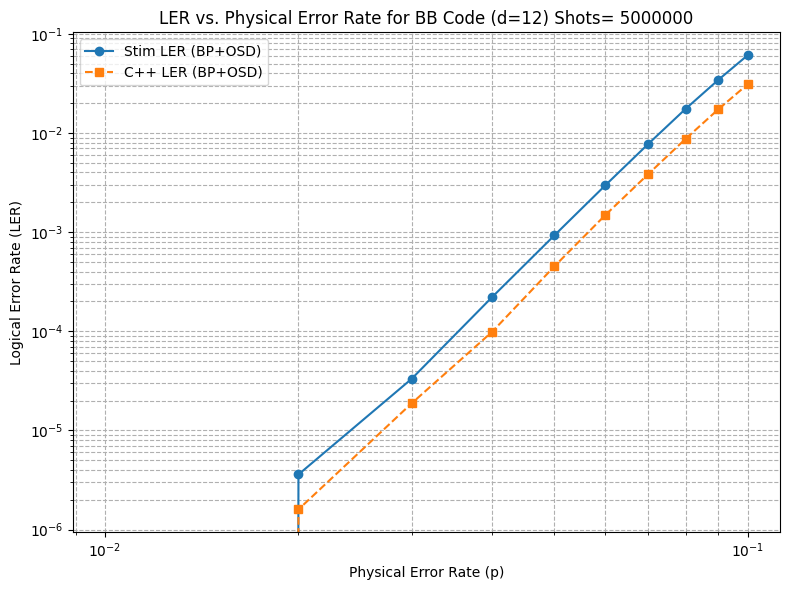

In [ ]:
# --- Plotting Results ---
plt.figure(figsize=(8, 6))

plt.plot(tau/T1, stim_logical_error_rates, 'o-', label='Stim LER (BP+OSD)')
plt.plot(tau/T1, cpp_logical_error_rates, 's--', label='C++ LER (BP+OSD)')
plt.xlabel("Physical Error Rate (p)")
plt.ylabel("Logical Error Rate (LER)")
plt.title(f"LER vs. Physical Error Rate for BB Code (d={distance}) Shots= {SHOTS}")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Reload and plot previously saved results ---

# Ensure these parameters match the saved files you want to load
# SHOTS = 50000000
# distance = 12
# T1 = 10**-4
# T2 = 10**-4

try:
    results_dir = "./results"
    stim_results_path = Path(results_dir) / f"stim_bposd_results_d{distance}_shots{SHOTS}.txt"
    cpp_results_path = Path(results_dir) / f"cpp_bposd_results_d{distance}_shots{SHOTS}.txt"

    # Check if files exist
    if not stim_results_path.exists() or not cpp_results_path.exists():
        missing = []
        if not stim_results_path.exists(): missing.append(str(stim_results_path))
        if not cpp_results_path.exists(): missing.append(str(cpp_results_path))
        raise FileNotFoundError("Missing results files: " + ", ".join(missing))

    # Function to load data from a tab-separated file
    def load_results(path):
        data = np.loadtxt(path, comments='#', delimiter='\t')
        # Assuming columns are: tau, p_amp, p_phase, ler
        return data[:, 0], data[:, 3]

    # Load data
    tau_s, stim_ler_s = load_results(stim_results_path)
    tau_c, cpp_ler_c = load_results(cpp_results_path)

    # --- Plotting ---
    plt.figure(figsize=(8, 6))
    plt.plot(tau_s / T1, stim_ler_s, 'o-', label='Stim LER (BP+OSD) [loaded]')
    plt.plot(tau_c / T1, cpp_ler_c, 's--', label='C++ LER (BP+OSD) [loaded]')
    
    plt.xlabel(r"$\tau / T1$ Ratio")
    plt.ylabel("Logical Error Rate (LER)")
    plt.title(f"Loaded LER for BB Code (d={distance}), Shots={SHOTS}")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Failed to load and plot")

Failed to load and plot


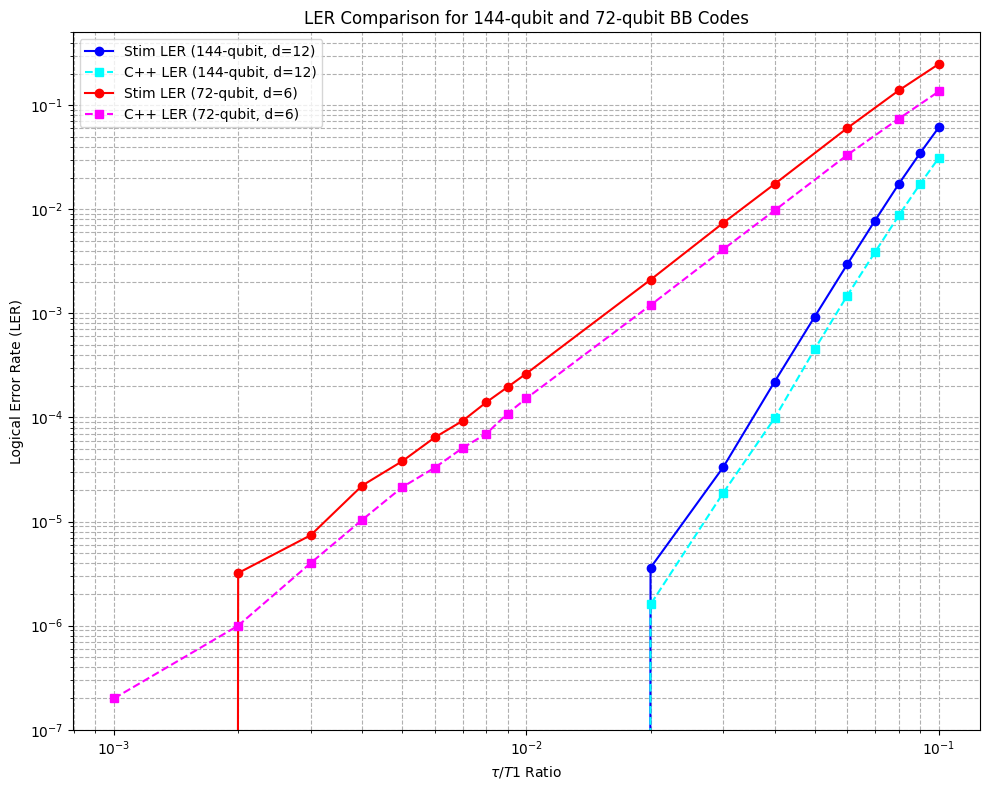

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Parameters for the experiments ---
# You may need to adjust these to match your saved data files
SHOTS_144 = 5000000
DISTANCE_144 = 12
RESULTS_DIR_144 = "./bposd_results"

# Parameters for the 72-qubit code. Adjust if necessary.
SHOTS_72 = 5000000 
DISTANCE_72 = 6
RESULTS_DIR_72 = "./bposd_72_results"

T1 = 10**-4
T2 = 10**-4

# Function to load data from a tab-separated file
def load_results(path):
    """Loads tau and LER from a results file."""
    try:
        if not path.exists():
            print(f"Warning: Results file not found at {path}")
            return None, None
        data = np.loadtxt(path, comments='#', delimiter='\t')
        # Assuming columns are: tau, p_amp, p_phase, ler
        return data[:, 0], data[:, 3]
    except Exception as e:
        print(f"Warning: Failed to load {path}. Error: {e}")
        return None, None

# --- Load Data ---
# 144-qubit data
stim_path_144 = Path(RESULTS_DIR_144) / f"stim_bposd_results_d{DISTANCE_144}_shots{SHOTS_144}.txt"
cpp_path_144 = Path(RESULTS_DIR_144) / f"cpp_bposd_results_d{DISTANCE_144}_shots{SHOTS_144}.txt"
tau_s_144, stim_ler_144 = load_results(stim_path_144)
tau_c_144, cpp_ler_144 = load_results(cpp_path_144)

# 72-qubit data
stim_path_72 = Path(RESULTS_DIR_72) / f"stim_bposd_results_d{DISTANCE_72}_shots{SHOTS_72}.txt"
cpp_path_72 = Path(RESULTS_DIR_72) / f"cpp_bposd_results_d{DISTANCE_72}_shots{SHOTS_72}.txt"
tau_s_72, stim_ler_72 = load_results(stim_path_72)
tau_c_72, cpp_ler_72 = load_results(cpp_path_72)


# --- Plotting ---
plt.figure(figsize=(10, 8))

# Plot 144-qubit results if data was loaded
if tau_s_144 is not None and stim_ler_144 is not None:
    plt.plot(tau_s_144 / T1, stim_ler_144, 'o-', label=f'Stim LER (144-qubit, d={DISTANCE_144})', color='blue')
if tau_c_144 is not None and cpp_ler_144 is not None:
    plt.plot(tau_c_144 / T1, cpp_ler_144, 's--', label=f'C++ LER (144-qubit, d={DISTANCE_144})', color='cyan')

# Plot 72-qubit results if data was loaded
if tau_s_72 is not None and stim_ler_72 is not None:
    plt.plot(tau_s_72 / T1, stim_ler_72, 'o-', label=f'Stim LER (72-qubit, d={DISTANCE_72})', color='red')
if tau_c_72 is not None and cpp_ler_72 is not None:
    plt.plot(tau_c_72 / T1, cpp_ler_72, 's--', label=f'C++ LER (72-qubit, d={DISTANCE_72})', color='magenta')

plt.xlabel(r"$\tau / T1$ Ratio")
plt.ylabel("Logical Error Rate (LER)")
plt.title(f"LER Comparison for 144-qubit and 72-qubit BB Codes")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()

Loading Stim data from: bposd_results/stim_bposd_results_d12_shots5000000.txt
Loading C++ data from: bposd_results/cpp_bposd_results_d12_shots5000000.txt
Loading d=12 Stim data from: bposd_results/stim_bposd_results_d12_shots5000000.txt
Loading d=12 C++ data from: bposd_results/cpp_bposd_results_d12_shots5000000.txt
Loading d=6 Stim data from: bposd_72_results/stim_bposd_results_d6_shots5000000.txt
Loading d=6 C++ data from: bposd_72_results/cpp_bposd_results_d6_shots5000000.txt


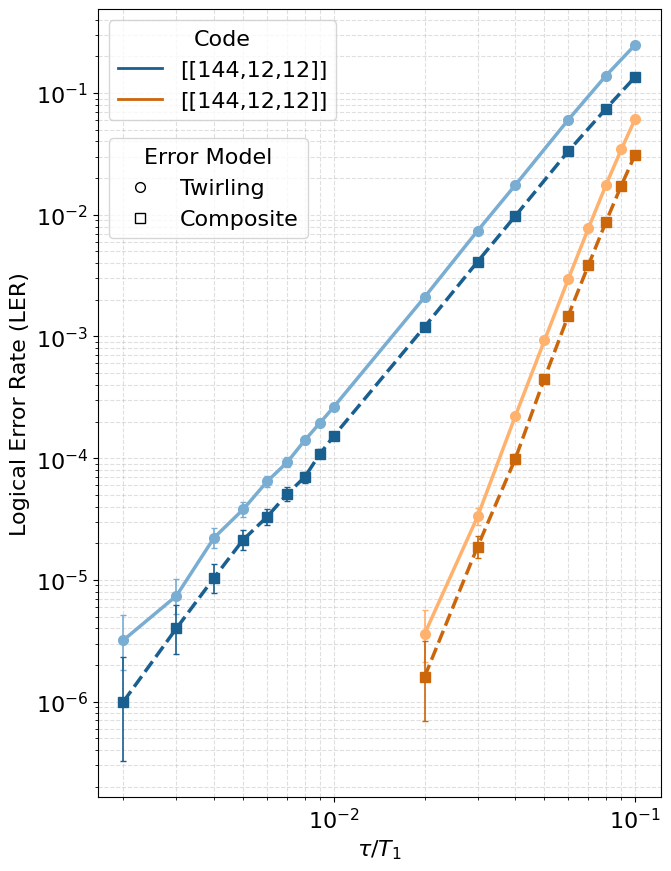

In [ ]:
# Regenerate plot from saved JSON results (with Poisson/Garwood intervals)
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from pathlib import Path

# --- Interval helpers ---
def garwood_interval(k, N, alpha=0.05):
    """
    95% (1-alpha) Garwood interval for a Poisson mean λ given count k,
    then converted to a rate p = λ/N.
    For k=0, returns [0, -ln(alpha)/N].
    """
    try:
        from scipy.stats import chi2
    except Exception as e:
        raise ImportError(
            "This cell needs scipy for chi-square quantiles. Try: pip install scipy"
        ) from e

    if k < 0 or N <= 0:
        return (np.nan, np.nan)
    if k == 0:
        lam_lo = 0.0
        lam_hi = -np.log(alpha)  # one-sided upper
    else:
        lam_lo = 0.5 * chi2.ppf(alpha / 2.0, 2 * k)
        lam_hi = 0.5 * chi2.ppf(1 - alpha / 2.0, 2 * (k + 1))
    return (lam_lo / N, lam_hi / N)

# --- Load results ---
SHOTS = 5000000
DISTANCE = 12
experiments = {
    12: {
        "shots": 5000000,
        "dir": Path("./bposd_results"),
    },
    6: {
        "shots": 5000000,
        "dir": Path("./bposd_72_results"),
    }
}

results_dir = Path("./bposd_results")

stim_path = results_dir / f"stim_bposd_results_d{DISTANCE}_shots{SHOTS}.txt"
cpp_path = results_dir / f"cpp_bposd_results_d{DISTANCE}_shots{SHOTS}.txt"

if not stim_path.exists() or not cpp_path.exists():
    raise FileNotFoundError(f"Could not find BB code result files in {results_dir}")

print(f"Loading Stim data from: {stim_path}")
print(f"Loading C++ data from: {cpp_path}")

# Load data from tab-separated files
stim_data = np.loadtxt(stim_path, comments='#', delimiter='\t')
cpp_data = np.loadtxt(cpp_path, comments='#', delimiter='\t')

# Assuming columns are: tau, p_amp, p_phase, ler
tau = stim_data[:, 0]
stim_lers = stim_data[:, 3]
cpp_lers = cpp_data[:, 3]

# Structure the data similarly to the original cell for the plotting loop
stim_results = {}
cpp_results = {}
tau_results = {}

# --- Function to load data from a tab-separated file ---
def load_data(path):
    if not path.exists():
        print(f"Warning: Results file not found at {path}")
        return None, None
    try:
        data = np.loadtxt(path, comments='#', delimiter='\t')
        # Assuming columns are: tau, p_amp, p_phase, ler
        return data[:, 0], data[:, 3]
    except Exception as e:
        print(f"Warning: Failed to load {path}. Error: {e}")
        return None, None

# --- Load all data ---
for d, params in experiments.items():
    shots = params["shots"]
    results_dir = params["dir"]
    
    stim_path = results_dir / f"stim_bposd_results_d{d}_shots{shots}.txt"
    cpp_path = results_dir / f"cpp_bposd_results_d{d}_shots{shots}.txt"

    print(f"Loading d={d} Stim data from: {stim_path}")
    tau_s, stim_ler = load_data(stim_path)
    
    print(f"Loading d={d} C++ data from: {cpp_path}")
    tau_c, cpp_ler = load_data(cpp_path)

    if stim_ler is not None and cpp_ler is not None:
        # Assuming tau is the same for both stim and cpp runs
        stim_results[d] = stim_ler
        cpp_results[d] = cpp_ler
        tau_results[d] = tau_s

plt.figure(figsize=(7, 9))
plt.rcParams.update({'font.size': 16})

def lighten(color, factor=0.6):
    c = np.array(mcolors.to_rgb(color))
    return tuple(1 - (1 - c) * factor)

def darken(color, factor=0.8):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c * factor)

cmap = plt.get_cmap('tab10')
color_handles = []

alpha = 0.05  # 95% intervals

for i, d in enumerate(sorted(stim_results.keys())):
    base = cmap(i % cmap.N)
    stim_color = lighten(base, 0.6)
    cpp_color  = darken(base, 0.8)

    shots = experiments[d]["shots"]
    x_vals_all = np.asarray(tau_results[d] / T1, dtype=float)
    y_stim_all = np.asarray(stim_results[d], dtype=float)
    y_cpp_all  = np.asarray(cpp_results.get(d, np.zeros_like(y_stim_all)), dtype=float)

    # This filter might be too aggressive when comparing different codes, consider removing
    # filter_mask = y_cpp_all <= y_stim_all
    filter_mask = x_vals_all > 10**-3 # Plot points where tau/T1 > 1e-3
    x_vals = x_vals_all[filter_mask]
    y_stim = y_stim_all[filter_mask]
    y_cpp  = y_cpp_all[filter_mask]

    # Convert rates to counts (rounded to nearest int)
    k_stim = np.rint(y_stim * shots).astype(int)
    k_cpp  = np.rint(y_cpp  * shots).astype(int)

    # Build intervals
    stim_lo = np.empty_like(y_stim)
    stim_hi = np.empty_like(y_stim)
    cpp_lo  = np.empty_like(y_cpp)
    cpp_hi  = np.empty_like(y_cpp)

    for idx in range(len(y_stim)):
        lo, hi = garwood_interval(int(k_stim[idx]), shots, alpha=alpha)
        stim_lo[idx], stim_hi[idx] = lo, hi
    for idx in range(len(y_cpp)):
        lo, hi = garwood_interval(int(k_cpp[idx]), shots, alpha=alpha)
        cpp_lo[idx], cpp_hi[idx] = lo, hi

    # Masks for k>0 vs k=0 (upper limits)
    stim_pos = k_stim > 0
    stim_zero = ~stim_pos
    cpp_pos  = k_cpp  > 0
    cpp_zero = ~cpp_pos

    plotted_any = False

    # --- Stim: k>0 points with asymmetric error bars ---
    if np.any(stim_pos):
        yhat = y_stim[stim_pos]
        yerr = np.vstack([yhat - stim_lo[stim_pos], stim_hi[stim_pos] - yhat])
        plt.errorbar(
            x_vals[stim_pos], yhat, yerr=yerr,
            fmt='o-', linewidth=2.5, markersize=7,
            color=stim_color, ecolor=stim_color, elinewidth=1.2, capsize=2.5,
            label=f'Pauli Twirling d={d}'
        )
        plotted_any = True

    # --- Stim: k=0 as 95% upper limits (down-triangle at upper bound) ---
    # if np.any(stim_zero):
    #     plt.scatter(
    #         x_vals[stim_zero], stim_hi[stim_zero],  # place marker at the upper limit
    #         marker='v', s=30, color=stim_color, label=None, zorder=3
    #     )
    #     # small vertical ticks to indicate limit (optional)
    #     for xv, yv in zip(x_vals[stim_zero], stim_hi[stim_zero]):
    #         plt.plot([xv, xv], [yv*0.97, yv], color=stim_color, lw=1)

    # --- C++: k>0 points with asymmetric error bars ---
    if np.any(cpp_pos):
        yhat = y_cpp[cpp_pos]
        yerr = np.vstack([yhat - cpp_lo[cpp_pos], cpp_hi[cpp_pos] - yhat])
        plt.errorbar(
            x_vals[cpp_pos], yhat, yerr=yerr,
            fmt='s--', linewidth=2.5, markersize=7,
            color=cpp_color, ecolor=cpp_color, elinewidth=1.2, capsize=2.5,
            label=f'Composite Damping d={d}'
        )
        plotted_any = True

    # --- C++: k=0 as 95% upper limits ---
    # if np.any(cpp_zero):
    #     plt.scatter(
    #         x_vals[cpp_zero], cpp_hi[cpp_zero],
    #         marker='v', s=30, color=cpp_color, label=None, zorder=3
    #     )
    #     for xv, yv in zip(x_vals[cpp_zero], cpp_hi[cpp_zero]):
    #         plt.plot([xv, xv], [yv*0.97, yv], color=cpp_color, lw=1)

    if plotted_any:
        color_handles.append(Line2D([0], [0], color=cpp_color, lw=2, label=f'[[144,12,12]]'))

plt.xlabel(r"$\tau / T_1$")
plt.ylabel("Logical Error Rate (LER)")
# plt.title(r"Rotated Surface Code Z-Memory: LER vs $\tau/T_1$")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4)

ax = plt.gca()

# Legend 1: marker shapes (black & white)
shape_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Twirling'),
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Composite'),
    # Line2D([0], [0], marker='v', linestyle='None',
    #        markerfacecolor='white', markeredgecolor='black',
    #        color='black', markersize=7, label='95% upper limit (k=0)'),
]
shape_legend = ax.legend(handles=shape_handles, title='Error Model',
                         loc='upper left', bbox_to_anchor=[0,.85])
ax.add_artist(shape_legend)

# Legend 2: distance colors (dark only)
if color_handles:
    ax.legend(handles=color_handles, title='Code', loc='upper left', ncol=1)

# Save figure
plt.tight_layout()
plt.savefig(f'../../figures/bb_code_LER_{SHOTS}_from_saved.pdf', dpi=500, bbox_inches='tight')
plt.show()


Loading Stim data from: bposd_results/stim_bposd_results_d12_shots5000000_save.txt
Loading C++ data from: bposd_results/cpp_bposd_results_d12_shots5000000_save.txt
Loading d=12 Stim data from: bposd_results/stim_bposd_results_d12_shots5000000_save.txt
Loading d=12 C++ data from: bposd_results/cpp_bposd_results_d12_shots5000000_save.txt
Loading d=12 Depolarizing data from: bposd_results/stim_bposd_results_d12_shots5000000_newdep.txt
Loading d=6 Stim data from: bposd_72_results/stim_bposd_results_d6_shots5000000_save.txt
Loading d=6 C++ data from: bposd_72_results/cpp_bposd_results_d6_shots5000000_save.txt
Loading d=6 Depolarizing data from: bposd_72_results/stim_bposd_results_d6_shots5000000_newdep.txt


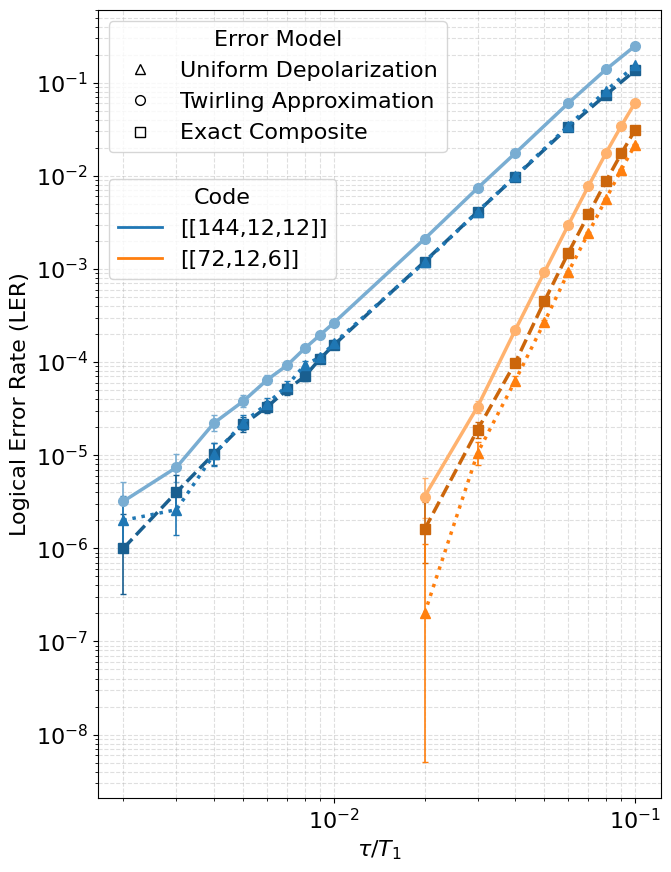

In [ ]:
# Regenerate plot from saved JSON results (with Poisson/Garwood intervals)
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from pathlib import Path

# --- Interval helpers ---
def garwood_interval(k, N, alpha=0.05):
    """
    95% (1-alpha) Garwood interval for a Poisson mean λ given count k,
    then converted to a rate p = λ/N.
    For k=0, returns [0, -ln(alpha)/N].
    """
    try:
        from scipy.stats import chi2
    except Exception as e:
        raise ImportError(
            "This cell needs scipy for chi-square quantiles. Try: pip install scipy"
        ) from e

    if k < 0 or N <= 0:
        return (np.nan, np.nan)
    if k == 0:
        lam_lo = 0.0
        lam_hi = -np.log(alpha)  # one-sided upper
    else:
        lam_lo = 0.5 * chi2.ppf(alpha / 2.0, 2 * k)
        lam_hi = 0.5 * chi2.ppf(1 - alpha / 2.0, 2 * (k + 1))
    return (lam_lo / N, lam_hi / N)

# --- Load results ---
SHOTS = 5000000
DISTANCE = 12
experiments = {
    12: {
        "shots": 5000000,
        "dir": Path("./bposd_results"),
    },
    6: {
        "shots": 5000000,
        "dir": Path("./bposd_72_results"),
    }
}

results_dir = Path("./bposd_results")

stim_path = results_dir / f"stim_bposd_results_d{DISTANCE}_shots{SHOTS}_save.txt"
dep_path = results_dir / f"stim_bposd_results_d{DISTANCE}_shots{SHOTS}_dep.txt"

cpp_path = results_dir / f"cpp_bposd_results_d{DISTANCE}_shots{SHOTS}_save.txt"

if not stim_path.exists() or not cpp_path.exists():
    raise FileNotFoundError(f"Could not find BB code result files in {results_dir}")

print(f"Loading Stim data from: {stim_path}")
print(f"Loading C++ data from: {cpp_path}")

# Load data from tab-separated files
stim_data = np.loadtxt(stim_path, comments='#', delimiter='\t')
cpp_data = np.loadtxt(cpp_path, comments='#', delimiter='\t')

# Assuming columns are: tau, p_amp, p_phase, ler
tau = stim_data[:, 0]
stim_lers = stim_data[:, 3]
cpp_lers = cpp_data[:, 3]

# Structure the data similarly to the original cell for the plotting loop
stim_results = {}
cpp_results = {}
dep_results = {}
tau_results = {}

# --- Function to load data from a tab-separated file ---
def load_data(path):
    if not path.exists():
        print(f"Warning: Results file not found at {path}")
        return None, None
    try:
        data = np.loadtxt(path, comments='#', delimiter='\t')
        # Assuming columns are: tau, p_amp, p_phase, ler
        return data[:, 0], data[:, 3]
    except Exception as e:
        print(f"Warning: Failed to load {path}. Error: {e}")
        return None, None

# --- Load all data ---
for d, params in experiments.items():
    shots = params["shots"]
    results_dir = params["dir"]
    
    stim_path = results_dir / f"stim_bposd_results_d{d}_shots{shots}_save.txt"
    cpp_path = results_dir / f"cpp_bposd_results_d{d}_shots{shots}_save.txt"
    dep_path = results_dir / f"stim_bposd_results_d{d}_shots{shots}_newdep.txt"

    print(f"Loading d={d} Stim data from: {stim_path}")
    tau_s, stim_ler = load_data(stim_path)
    
    print(f"Loading d={d} C++ data from: {cpp_path}")
    tau_c, cpp_ler = load_data(cpp_path)

    print(f"Loading d={d} Depolarizing data from: {dep_path}")
    tau_dep, dep_ler = load_data(dep_path)

    if stim_ler is not None and cpp_ler is not None:
        # Assuming tau is the same for all runs
        stim_results[d] = stim_ler
        cpp_results[d] = cpp_ler
        if dep_ler is not None:
            dep_results[d] = dep_ler
        tau_results[d] = tau_s

plt.figure(figsize=(7, 9))
plt.rcParams.update({'font.size': 16})

def lighten(color, factor=0.6):
    c = np.array(mcolors.to_rgb(color))
    return tuple(1 - (1 - c) * factor)

def darken(color, factor=0.8):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c * factor)

cmap = plt.get_cmap('tab10')
color_handles = []

alpha = 0.05  # 95% intervals
T1=10**-4
for i, d in enumerate(sorted(stim_results.keys())):
    base = cmap(i % cmap.N)
    stim_color = lighten(base, 0.6)
    cpp_color  = darken(base, 0.8)
    dep_color = base # Use the base color for the third model

    shots = experiments[d]["shots"]
    
    x_vals_all = np.asarray(tau_results[d] / T1, dtype=float)
    y_stim_all = np.asarray(stim_results[d], dtype=float)
    y_cpp_all  = np.asarray(cpp_results.get(d, np.zeros_like(y_stim_all)), dtype=float)
    y_dep_all = np.asarray(dep_results.get(d, np.full_like(y_stim_all, np.nan)), dtype=float)

    # This filter might be too aggressive when comparing different codes, consider removing
    # filter_mask = y_cpp_all <= y_stim_all
    filter_mask = x_vals_all > 10**-3 # Plot points where tau/T1 > 1e-3
    x_vals = x_vals_all[filter_mask]
    y_stim = y_stim_all[filter_mask]
    y_cpp  = y_cpp_all[filter_mask]
    y_dep = y_dep_all[filter_mask]

    # Convert rates to counts (rounded to nearest int)
    k_stim = np.rint(y_stim * shots).astype(int)
    k_cpp  = np.rint(y_cpp  * shots).astype(int)
    k_dep = np.rint(y_dep * shots).astype(int)

    # Build intervals
    stim_lo = np.empty_like(y_stim)
    stim_hi = np.empty_like(y_stim)
    cpp_lo  = np.empty_like(y_cpp)
    cpp_hi  = np.empty_like(y_cpp)
    dep_lo = np.empty_like(y_dep)
    dep_hi = np.empty_like(y_dep)

    for idx in range(len(y_stim)):
        lo, hi = garwood_interval(int(k_stim[idx]), shots, alpha=alpha)
        stim_lo[idx], stim_hi[idx] = lo, hi
    for idx in range(len(y_cpp)):
        lo, hi = garwood_interval(int(k_cpp[idx]), shots, alpha=alpha)
        cpp_lo[idx], cpp_hi[idx] = lo, hi
    for idx in range(len(y_dep)):
        if not np.isnan(k_dep[idx]):
            lo, hi = garwood_interval(int(k_dep[idx]), shots, alpha=alpha)
            dep_lo[idx], dep_hi[idx] = lo, hi
        else:
            dep_lo[idx], dep_hi[idx] = np.nan, np.nan

    # Masks for k>0 vs k=0 (upper limits)
    stim_pos = k_stim > 0
    stim_zero = ~stim_pos
    cpp_pos  = k_cpp  > 0
    cpp_zero = ~cpp_pos
    dep_pos = k_dep > 0
    dep_zero = ~dep_pos

    plotted_any = False

    # --- Stim: k>0 points with asymmetric error bars ---
    if np.any(stim_pos):
        yhat = y_stim[stim_pos]
        yerr = np.vstack([yhat - stim_lo[stim_pos], stim_hi[stim_pos] - yhat])
        plt.errorbar(
            x_vals[stim_pos], yhat, yerr=yerr,
            fmt='o-', linewidth=2.5, markersize=7,
            color=stim_color, ecolor=stim_color, elinewidth=1.2, capsize=2.5,
            label=f'Pauli Twirling Approx. d={d}'
        )
        plotted_any = True

    # --- Stim: k=0 as 95% upper limits (down-triangle at upper bound) ---
    # if np.any(stim_zero):
    #     plt.scatter(
    #         x_vals[stim_zero], stim_hi[stim_zero],  # place marker at the upper limit
    #         marker='v', s=30, color=stim_color, label=None, zorder=3
    #     )
    #     # small vertical ticks to indicate limit (optional)
    #     for xv, yv in zip(x_vals[stim_zero], stim_hi[stim_zero]):
    #         plt.plot([xv, xv], [yv*0.97, yv], color=stim_color, lw=1)

    # --- C++: k>0 points with asymmetric error bars ---
    if np.any(cpp_pos):
        yhat = y_cpp[cpp_pos]
        yerr = np.vstack([yhat - cpp_lo[cpp_pos], cpp_hi[cpp_pos] - yhat])
        plt.errorbar(
            x_vals[cpp_pos], yhat, yerr=yerr,
            fmt='s--', linewidth=2.5, markersize=7,
            color=cpp_color, ecolor=cpp_color, elinewidth=1.2, capsize=2.5,
            label=f'Composite Damping d={d}'
        )
        plotted_any = True

    # --- Depolarizing: k>0 points with asymmetric error bars ---
    if np.any(dep_pos):
        yhat = y_dep[dep_pos]
        yerr = np.vstack([yhat - dep_lo[dep_pos], dep_hi[dep_pos] - yhat])
        plt.errorbar(
            x_vals[dep_pos], yhat, yerr=yerr,
            fmt='^:', linewidth=2.5, markersize=7,
            color=dep_color, ecolor=dep_color, elinewidth=1.2, capsize=2.5,
            label=f'Uniform Depolarizing d={d}'
        )
        plotted_any = True

    # --- C++: k=0 as 95% upper limits ---
    # if np.any(cpp_zero):
    #     plt.scatter(
    #         x_vals[cpp_zero], cpp_hi[cpp_zero],
    #         marker='v', s=30, color=cpp_color, label=None, zorder=3
    #     )
    #     for xv, yv in zip(x_vals[cpp_zero], cpp_hi[cpp_zero]):
    #         plt.plot([xv, xv], [yv*0.97, yv], color=cpp_color, lw=1)

if plotted_any:
    color_handles.append(Line2D([0], [0], color=cmap(0 % cmap.N), lw=2, label=f'[[144,12,12]]'))
    color_handles.append(Line2D([0], [0], color=cmap(1 % cmap.N), lw=2, label=f'[[72,12,6]]'))

plt.xlabel(r"$\tau / T_1$")
plt.ylabel("Logical Error Rate (LER)")
# plt.title(r"Rotated Surface Code Z-Memory: LER vs $\tau/T_1$")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4)

ax = plt.gca()

# Legend 1: marker shapes (black & white)
shape_handles = [
    Line2D([0], [0], marker='^', linestyle='None',
        markerfacecolor='white', markeredgecolor='black',
        color='black', markersize=7, label='Uniform Depolarization'),
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Twirling Approximation'),
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Exact Composite'),

    # Line2D([0], [0], marker='v', linestyle='None',
    #        markerfacecolor='white', markeredgecolor='black',
    #        color='black', markersize=7, label='95% upper limit (k=0)'),
]
shape_legend = ax.legend(handles=shape_handles, title='Error Model',
                         loc='upper left')
ax.add_artist(shape_legend)

# Legend 2: distance colors (dark only)
if color_handles:
    ax.legend(handles=color_handles, title='Code', loc='upper left', bbox_to_anchor=[0,.8], ncol=1)

# Save figure
plt.tight_layout()
plt.savefig(f'../../figures/bb_code_LER_{SHOTS}_from_saved.pdf', dpi=500, bbox_inches='tight')
plt.show()